# Problem Statement:

'All You Need' Supermarket is planning for the year end sale - they want to launch a new offer i.e. gold membership for only \\$499 that is of \\$999 on normal days(that gives 20% discount on all purchases) only for existing customers, for that they need to do a campaign through phone calls - best way to reduce the cost of campaign is to make a predictive model to classify customers who might purchase 
the offer, using the data they gathered during last year campaign.
We will build a model for classifying whether customers will reply back with a positive response or not.

# Objective:
- What are the different factors which affect the target variable? What business recommendations can we give based on the analysis?
- How can we improve model performance using hyperparameter tuning and prevent data leakage using pipelines while building a model to predict the response of a customer?

### Data Dictionary

- Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise
- ID - Unique ID of each customer
- Year_Birth - Age of the customer
- Complain - 1 if customer complained in the last 2 years
- Dt_Customer - date of customer's enrollment with the company
- Education - customer's level of education
- Marital - customer's marital status
- Kidhome - number of small children in customer's household
- Teenhome - number of teenagers in customer's household
- Income - customer's yearly household income
- MntFishProducts - amount spent on fish products in the last 2 years
- MntMeatProducts - amount spent on meat products in the last 2 years
- MntFruits - amount spent on fruits products in the last 2 years
- MntSweetProducts - amount spent on sweet products in the last 2 years
- MntWines - amount spent on wine products in the last 2 years
- MntGoldProds - amount spent on gold products in the last 2 years
- NumDealsPurchases - number of purchases made with discount
- NumCatalogPurchases - number of purchases made using catalogue
- NumStorePurchases - number of purchases made directly in stores
- NumWebPurchases - number of purchases made through company's web site
- NumWebVisitsMonth - number of visits to company's web site in the last month
- Recency - number of days since the last purchase

## Import necessary libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline

#libraries to help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier)
from xgboost import XGBClassifier

## Load and view the dataset

In [2]:
data = pd.read_excel("marketing_data.xlsx")

In [3]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/14,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/14,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/14,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05 00:00:00,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04 00:00:00,0,6,...,11,0,34,2,3,1,2,7,1,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

- There are total 22 columns and 2,240 observations in the dataset
- We can see that income column have less than 2,240 non-null values i.e. column have missing values. We'll explore this further.

**Let's check the number of unique values in each column**

In [5]:
data.nunique()

ID                     2240
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1974
Kidhome                   3
Teenhome                  3
Dt_Customer             663
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
Response                  2
Complain                  2
dtype: int64

- We can drop the column - `ID` as it is unique for each customer and will not add value to the model.

In [6]:
# Dropping columns - ID
data.drop(columns=["ID"], inplace=True)

**Summary of the data**

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0
MntSweetProducts,2240.0,27.062946,41.280498,0.0,1.00,8.0,33.00,263.0


- `Year_Birth` has a large range of values i.e. 1893 to 1996.
- Columns - `MntFruits, MntWines, MntMeatProducts, MntFishProducts, MntSweetProducts` might have outliers on the right end as there is a large differene between between 75th percentile and maximum values.
- Recency has an aprrox equal mean and median which is equal to 49.
- Highest mean amount spent in the last two years is for wines (approx 304), followed by meat products (approx 167).
- The distribution of classes in the `Response` variable is imbalanced as most of the values are 0.

## Data Preprocessing

**Adding age of the customers to the data using given birth years**

In [8]:
# To calculate age we'll subtract the year 2016 because variables account for the last 2 years
# and we have customers registered till 2014 only
# We need to convert strings values to dates first to use subraction
data["Age"] = 2016 - pd.to_datetime(data["Year_Birth"], format="%Y").apply(
    lambda x: x.year
)

data["Age"].sort_values()

562      20
1824     20
697      21
1468     21
964      21
       ... 
1740     75
2171     76
2233    116
827     117
513     123
Name: Age, Length: 2240, dtype: int64

- We can see that there are 3 observations with age greater than 100 i.e. 116, 117 and 123 which is highly unlikely to be true.
- We can cap the value for age variables to the next highest value i.e. 76.

In [9]:
# Capping age variable
data["Age"].clip(upper=80, inplace=True)

In [10]:
data.Age.nlargest(15)

513     80
827     80
2233    80
2171    76
1740    75
1202    73
1208    73
1209    73
1350    73
1475    73
1644    73
1693    73
191     72
227     72
436     72
Name: Age, dtype: int64

**Using Dt_Customer to add features to the data**

In [11]:
# The feature Dt_Customer represents dates of customer’s enrollment with the company.
# Let's convert this to datetime format
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"]) 

In [12]:
# Extracting registration year from the date
data["Reg_year"] = data["Dt_Customer"].apply(lambda x: x.year)

# Extracting registration quarter from the date
data["Reg_quarter"] = data["Dt_Customer"].apply(lambda x: x.quarter)

# Extracting registration month from the date
data["Reg_month"] = data["Dt_Customer"].apply(lambda x: x.month)

# Extracting registration week from the date
data["Reg_week"] = data["Dt_Customer"].apply(lambda x: x.day // 7)

In [13]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Reg_week
0,1970,Graduation,Divorced,84835.0,0,0,2014-06-16,0,189,104,...,4,6,1,1,0,46,2014,2,6,2
1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,5,...,3,7,5,1,0,55,2014,2,6,2
2,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,11,...,2,5,2,0,0,58,2014,2,5,1
3,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,10,0,...,0,2,7,0,0,49,2014,4,11,0
4,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,6,16,...,1,2,7,1,0,27,2014,3,8,0


**Let's check the count of each unique category in each of the categorical variables.** 

In [14]:
# Making a list of all categorical variables
cat_col = [
    "Education",
    "Marital_Status",
    "Kidhome",
    "Teenhome",
    "Complain",
    "Response",
    "Reg_year",
    "Reg_quarter",
    "Reg_month",
    "Reg_week",
]

# Printing number of count of each unique value in each column
for column in cat_col:
    print(data[column].value_counts())
    print("-" * 40)

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64
----------------------------------------
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64
----------------------------------------
0    1293
1     899
2      48
Name: Kidhome, dtype: int64
----------------------------------------
0    1158
1    1030
2      52
Name: Teenhome, dtype: int64
----------------------------------------
0    2219
1      21
Name: Complain, dtype: int64
----------------------------------------
0    1906
1     334
Name: Response, dtype: int64
----------------------------------------
2013    1189
2014     557
2012     494
Name: Reg_year, dtype: int64
----------------------------------------
4    596
1    580
2    546
3    518
Name: Reg_quarter, dtype: int64
----------------------------------------
8     211
10    209
3     202
12 

- In education, 2n cycle and Master means the same thing. We can combine these two categories.
- There are many categories in martial status. We can combine categories 'Alone', 'Absurd' and 'YOLO' with 'Single' and 'Together' category with 'Married'.
- There are only 21 customers who complained in the last two years.
- We have 1906 observation for the 0 class but only 334 observations for the class 1.
- There are only three years in the customer registration data.

In [15]:
# Replacing 2n Cycle with Master
data["Education"] = data["Education"].replace("2n Cycle", "Master")

In [16]:
# Replacing YOLO, Alone, Absurd with single and Together with Married
data["Marital_Status"] = data["Marital_Status"].replace(
    ["YOLO", "Alone", "Absurd"], "Single"
)
data["Marital_Status"] = data["Marital_Status"].replace(["Together"], "Married")

**Imputing missing values in income column**

In [17]:
# number of missing values in each column
data.isnull().sum()

Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
Age                     0
Reg_year                0
Reg_quarter             0
Reg_month               0
Reg_week                0
dtype: int64

In [18]:
# Percentage of missing values in income column
round(data.isna().sum() / data.isna().count() * 100, 2)["Income"]

1.07

**We can add a column - total amount spent by each customer in the last 2 years**

In [19]:
data["Total_Amount_Spent"] = data[
    [
        "MntWines",
        "MntFruits",
        "MntMeatProducts",
        "MntFishProducts",
        "MntSweetProducts",
        "MntGoldProds",
    ]
].sum(axis=1)

## EDA

### Univariate

In [20]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical
# variable.
# This function takes the numerical column as the input and returns the boxplots
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(
        feature, kde=F, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.distplot(
        feature, kde=False, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        np.mean(feature), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        np.median(feature), color="black", linestyle="-"
    )  # Add median to the histogram

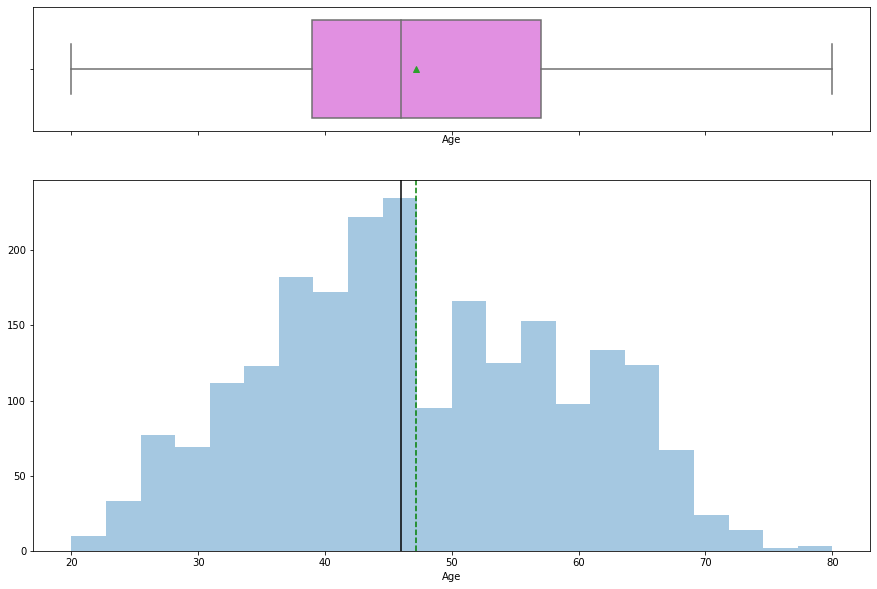

In [21]:
# Observations on Customer_age
histogram_boxplot(data["Age"])

- As per the boxplot, there are no outliers in 'Age' variable
- Age has a fairly normal distribution distribution with approx equal mean and median

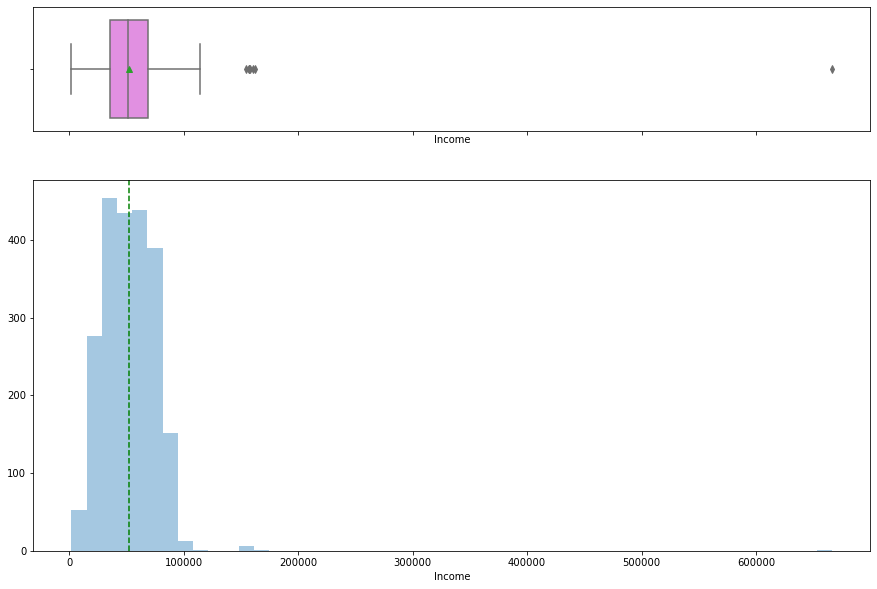

In [22]:
# observations on Income
histogram_boxplot(data["Income"])

- We can see there are some outliers in the income variable.
- Some variation is always expected in real world scenarios for the income variable but we can remove the data point on extreme right end of the boxplot as it can be a data entry error.

In [23]:
# handling the observaion with income greater than 20000. There is just 1 such observation
data["Income"].clip(upper=200000, inplace=True)


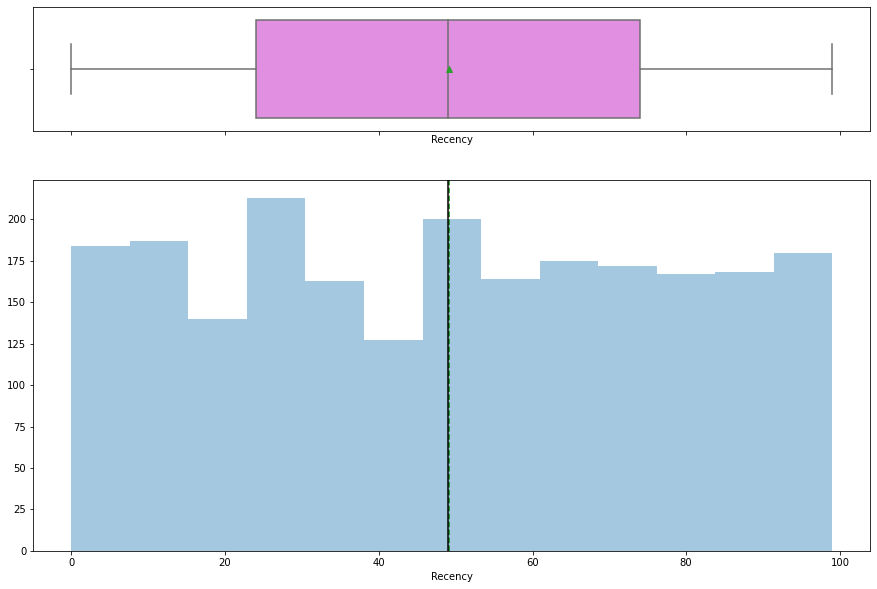

In [24]:
# observations on Recency
histogram_boxplot(data["Recency"])

- There are no outliers in 'Recency' variable
- The distribution is fairly symmetric and uniformly distributed.

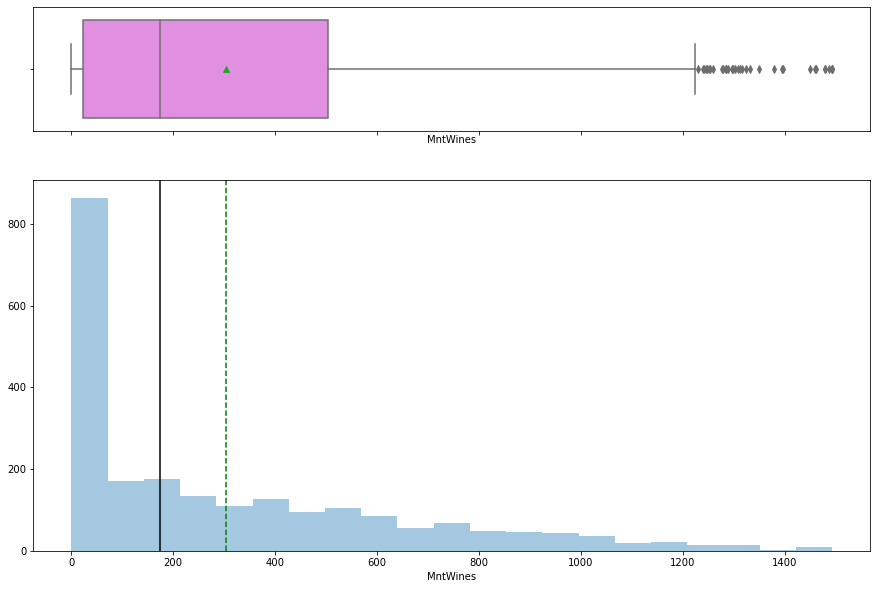

In [25]:
# observations on MntWines
histogram_boxplot(data["MntWines"])

- The distribution for amount spent on wines is highly skewed to the right
- As median of the distribution is less than 200, more than 50% of customers have spent less than 200 on wines.
- There are some outliers on the right end of the boxplot but we will not treat them as some variation is always expected in real world scenarios for variables like amount spent.

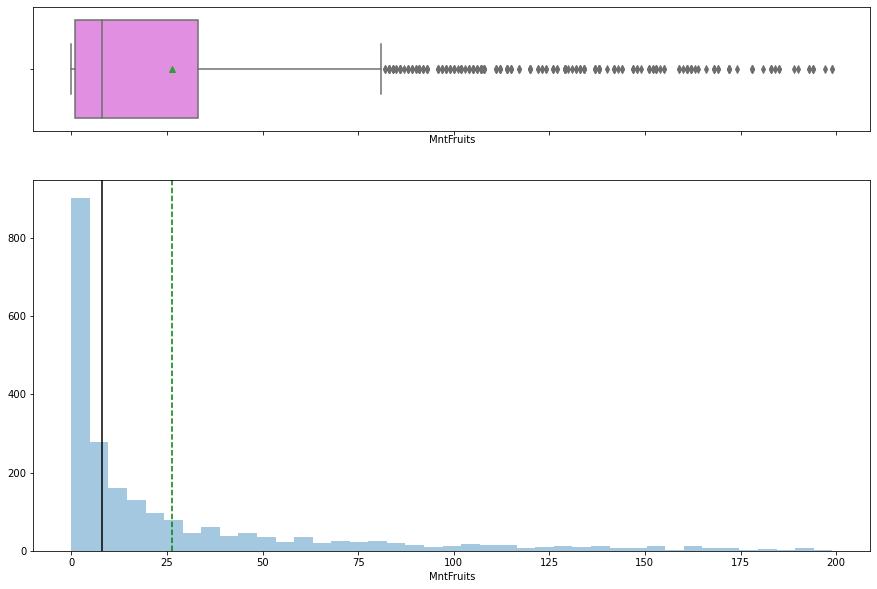

In [26]:
# observations on MntFruits
histogram_boxplot(data["MntFruits"])

- The distribution for amount spent on fruits is highly skewed to the right.
- As median of the distribution is less than 20, more than 50% of customers have spent less than 20 on fruits.
- There are some outliers on the right end of the boxplot but we will not treat them as some variation is always expected in real world scenarios for variables like amount spent.

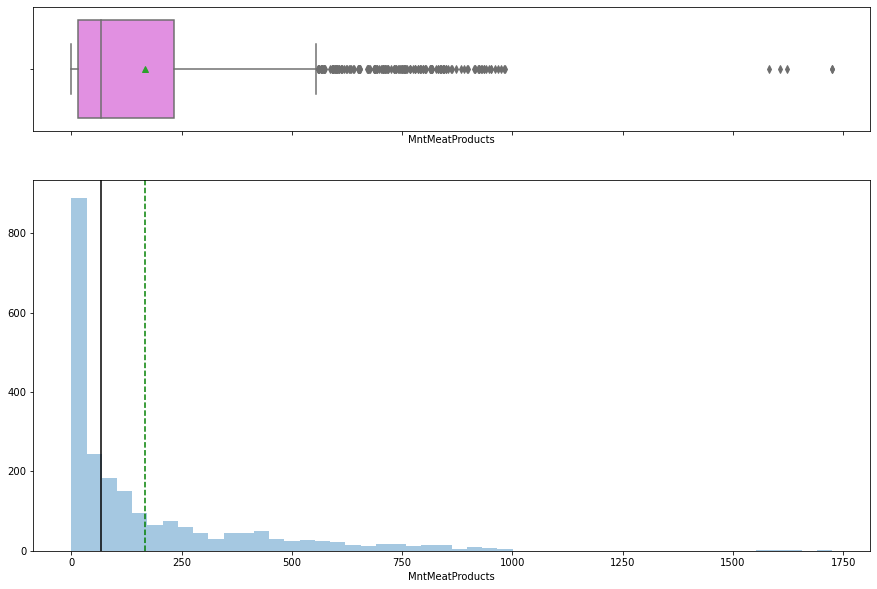

In [27]:
# observations on MntMeatProducts
histogram_boxplot(data["MntMeatProducts"])

- The distribution for amount spent on meat products is highly skewed to the right.
- We can see that there are some extreme observations in the variable which can be considered as outliers as they very far from the rest of the values. 
- We can cap the value of the variable to the next highest value.

In [28]:
data["MntMeatProducts"].clip(upper=1000, inplace=True)

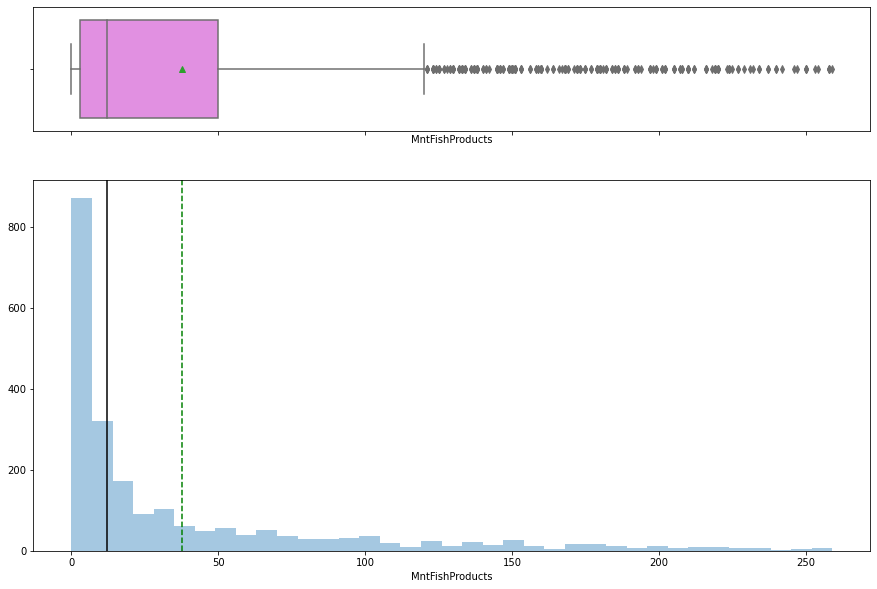

In [29]:
# observations on MntFishProducts
histogram_boxplot(data["MntFishProducts"])

- The distribution for amount spent on fish products is right skewed
- There are some outliers on the right end in the boxplot but we will not treat them as this represents real market trend that some customers spend more on fish products than others.

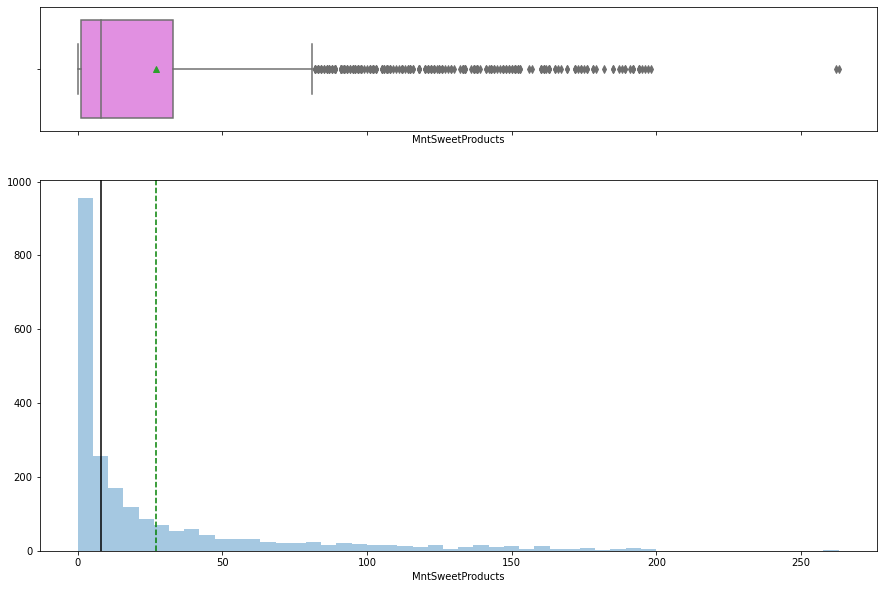

In [31]:
# observations on MntSweetProducts
histogram_boxplot(data["MntSweetProducts"])

- The distribution for the amount spent on sweet products is right skewed 
- There is one observation to the right extreme which can be considered as an outlier. 
- We will not remove all such data point as they represent real market trend but we can cap some of the extreme values.

In [32]:
# Capping values for amount spent on sweet products at 198
data["MntSweetProducts"].clip(upper=198, inplace=True)

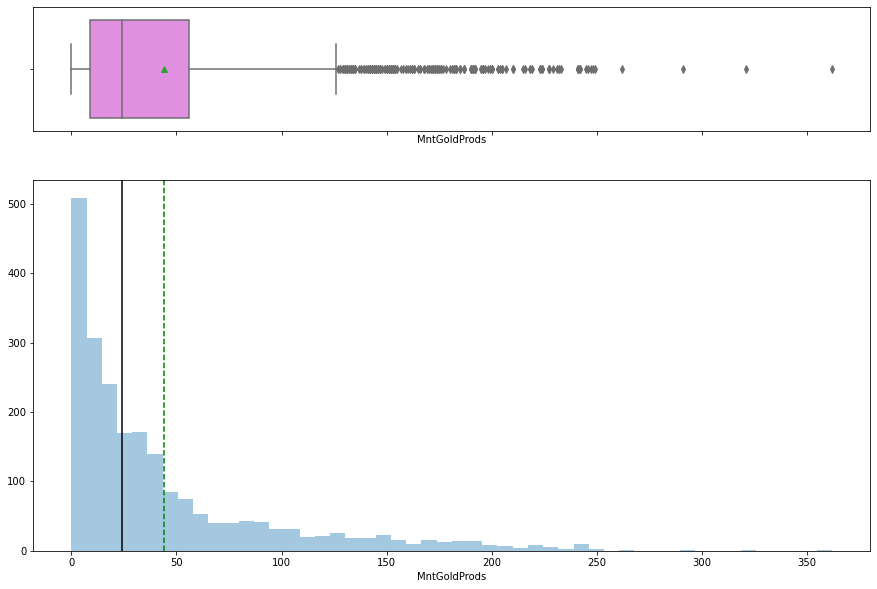

In [33]:
# observations on MntGoldProds
histogram_boxplot(data["MntGoldProds"])

- The distribution for the amount spent on gold products is right skewed 
- There are some outliers in amount spent on gold products. We will not remove all such data point as they represent real market trend but we can cap some of the extreme values.

In [34]:
# Capping values for amount spent on gold products at 250
data["MntGoldProds"].clip(upper=250, inplace=True)

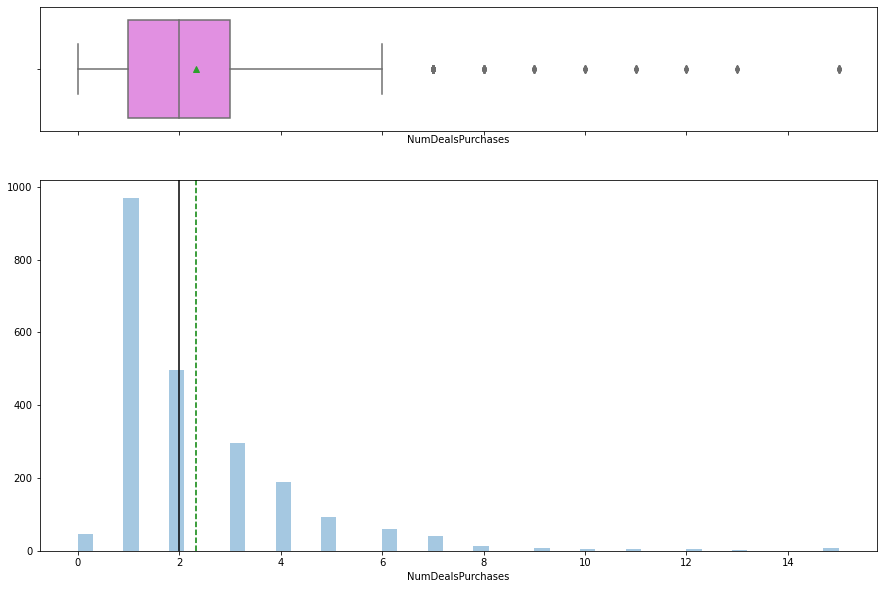

In [35]:
# observations on NumDealsPurchases
histogram_boxplot(data["NumDealsPurchases"])

In [36]:
data["NumDealsPurchases"].clip(upper=6, inplace=True)

In [40]:
data.groupby(['Response'])["NumDealsPurchases"].median()

Response
0    2
1    1
Name: NumDealsPurchases, dtype: int64

- Majority of the customers have 2 or less than 2 deal purchases. 
- We can see that there some extreme observations in the variable. This represents the real market trend.

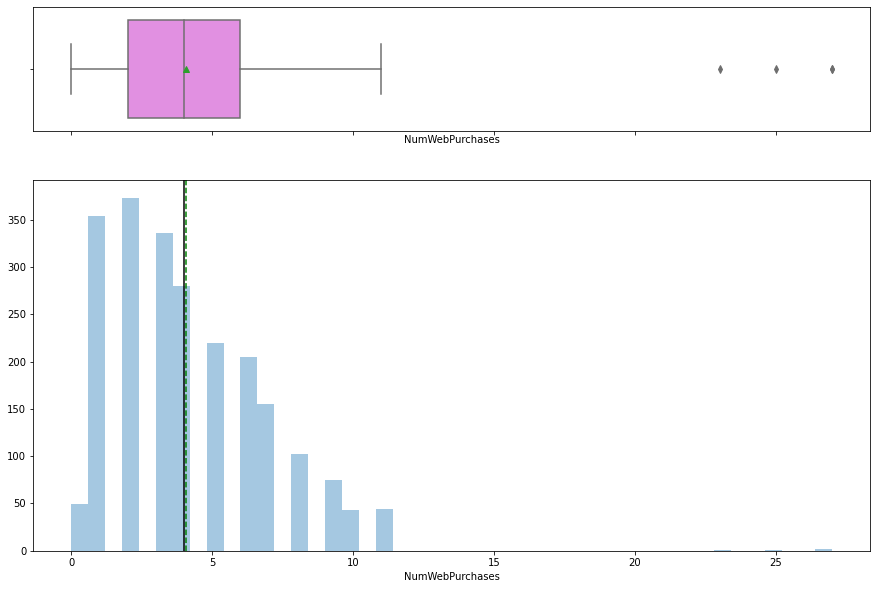

In [41]:
# observations on NumWebPurchases
histogram_boxplot(data["NumWebPurchases"])

- The median of the distribution is 4 i.e. 50% customers have 4 or less than 4 web purchases. 
- We can see that there are some extreme observations in the variable. We can cap these values to the next highest number of purchases.

In [42]:
# Capping values for number of web purchases at 11
data["NumWebPurchases"].clip(upper=20, inplace=True)

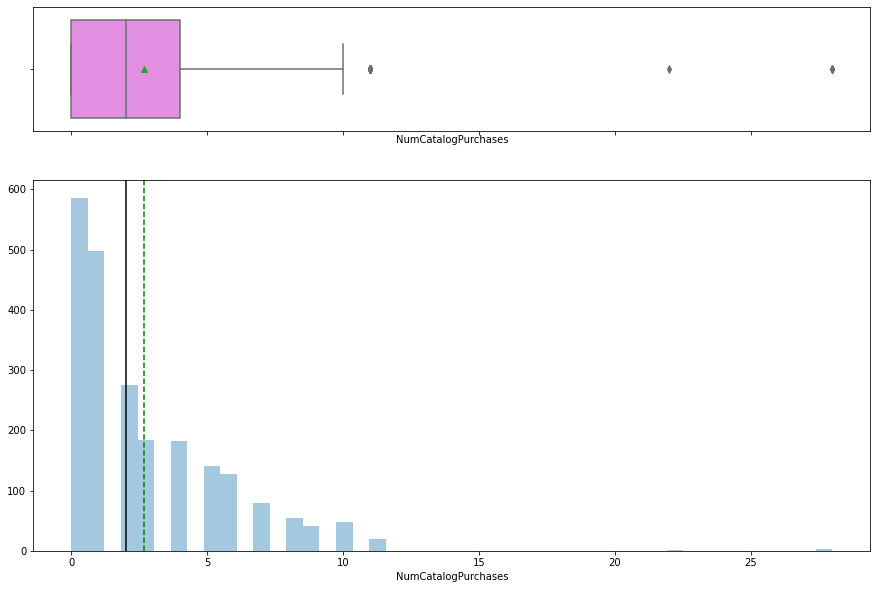

In [43]:
# observations on NumCatalogPurchases
histogram_boxplot(data["NumCatalogPurchases"])

- The most number of observations are for 0 catalog purchases.
- The median of the distribution is 2 i.e. 50% customers have 2 or less than 2 catalog purchases. 
- We can see that there are two extreme observation in the variable. We can cap these values to the next highest number of purchases.

In [44]:
# Capping values for number of catalog purchases at 11
data["NumCatalogPurchases"].clip(upper=11, inplace=True)

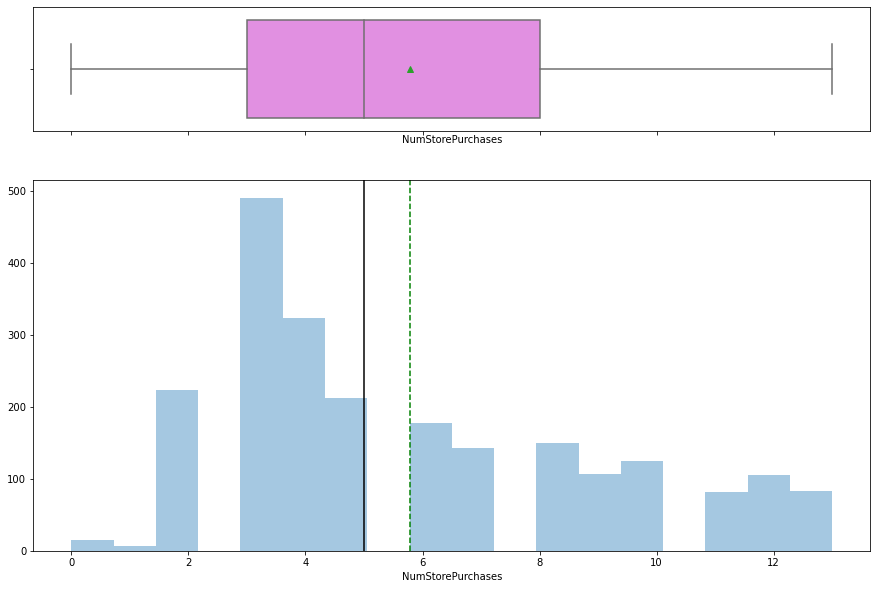

In [45]:
# observations on NumStorePurchases
histogram_boxplot(data["NumStorePurchases"])

- There are very few observations with less than 2 purchases from the store
- Most of the customers have 4 or 5 purchases from the store
- There are no outliers in this variable

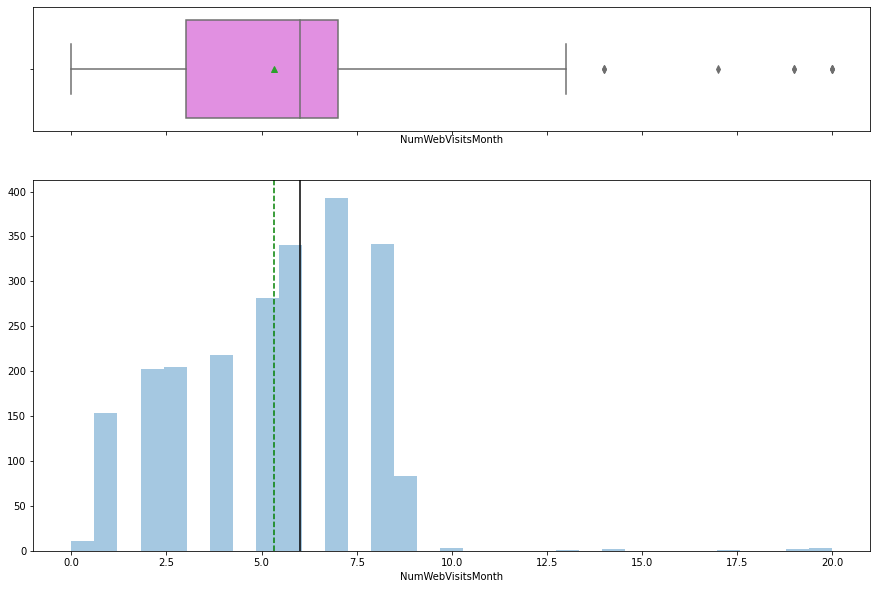

In [46]:
# observations on NumWebVisitsMonth
histogram_boxplot(data["NumWebVisitsMonth"])

In [47]:
# Capping values for amount spent on gold products at 250
data["NumWebVisitsMonth"].clip(upper=15, inplace=True)

- The distribution for number of visits in a month is skewed and have some outliers at the right end.
- We will not treat this as this represents general market trend

In [48]:
def perc_on_bar(feature):
    """
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    """
    # Creating a countplot for the feature
    sns.set(rc={"figure.figsize": (10, 5)})
    ax = sns.countplot(x=feature, data=data)

    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.1  # width of the plot
        y = p.get_y() + p.get_height()  # hieght of the plot
        ax.annotate(percentage, (x, y), size=14)  # annotate the percantage

    plt.show()  # show the plot

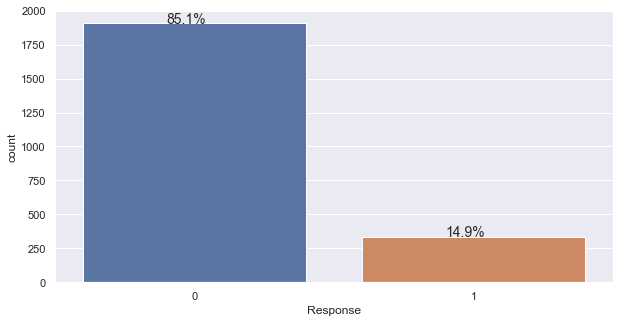

In [49]:
# observations on Response
perc_on_bar(data["Response"])

- Approx 85% customer's response was NO in the last campaign.
- This shows that the distribution of classes in the target variable is imbalanced. We have only ~15% observations where response is YES.

### Bivariate Analysis

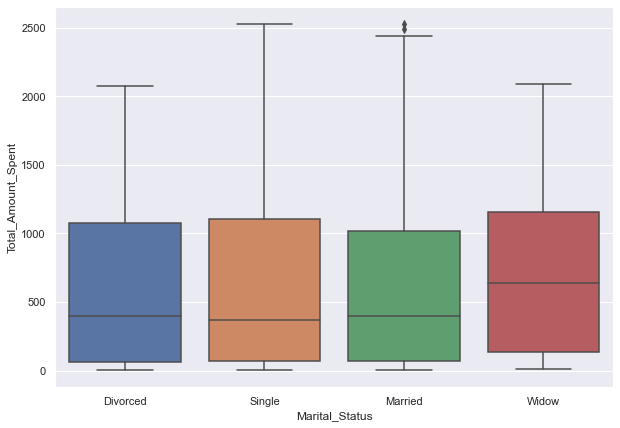

In [50]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(y="Total_Amount_Spent", x="Marital_Status", data=data, orient="vertical")

- We can see that total amount spent is higher for widowed customers.
- No significant difference in the amount spent by single, married or divorced customers.

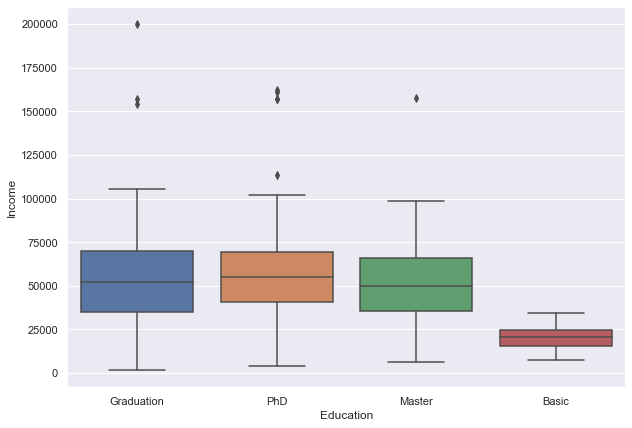

In [52]:
sns.boxplot(y="Income", x="Education", data=data, orient="vertical")

- As expected, the amount spent increases with the increase in education level.
- Customers with graduation level education spend slightly more than the customers with master level education. 

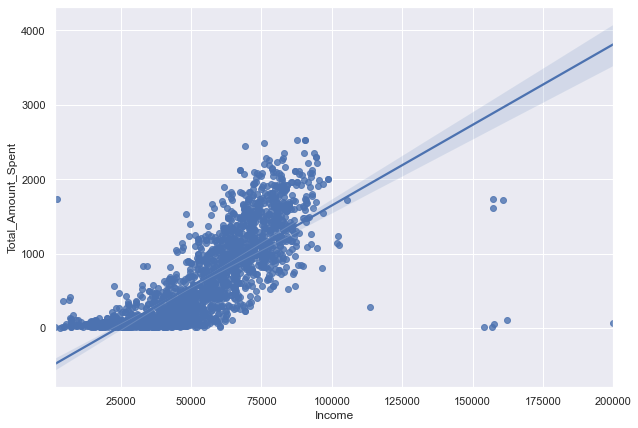

In [53]:
sns.regplot(y=data.Total_Amount_Spent, x=data.Income)

- We can see that income and the total amount spent have a positive correlation.
- The total amount spent is not much different for customers with income in the range of 20K to 60K but the difference is significant for customers in the range of 60K to 100K.

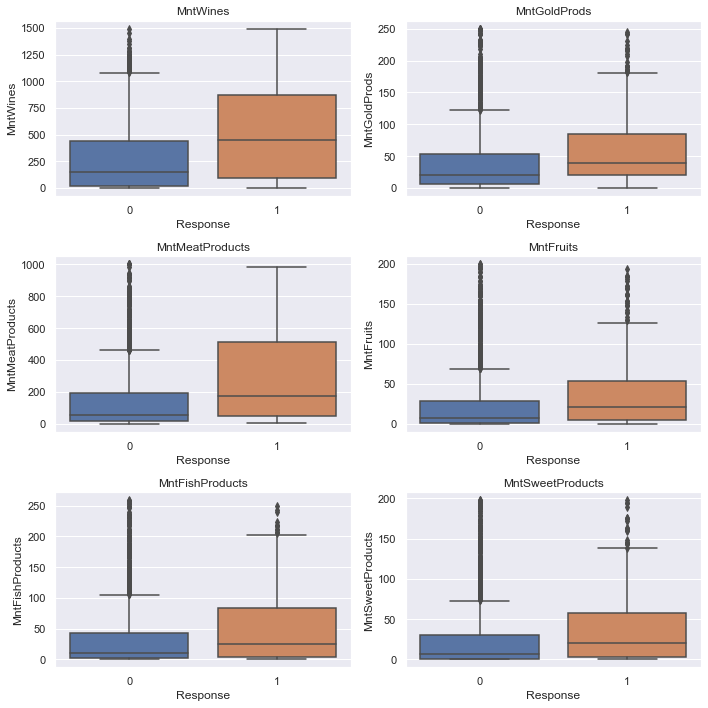

In [54]:
cols = data[
    [
        "MntWines",
        "MntGoldProds",
        "MntMeatProducts",
        "MntFruits",
        "MntFishProducts",
        "MntSweetProducts",
    ]
].columns.tolist()
plt.figure(figsize=(10, 10))

for i, variable in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(data["Response"], data[variable])
    plt.tight_layout()
    plt.title(variable)
plt.show()

- Each plot shows that customer spending more on any product is more likely to take the offer. 

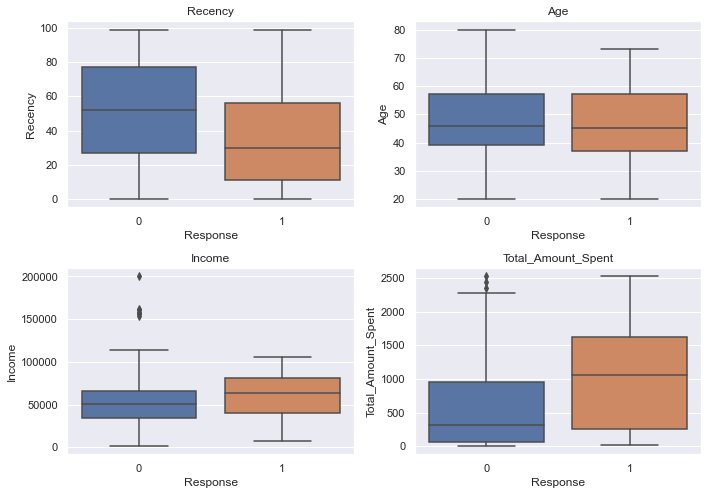

In [55]:
cols = data[["Recency", "Age", "Income", "Total_Amount_Spent"]].columns.tolist()
plt.figure(figsize=(10, 10))

for i, variable in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(data["Response"], data[variable])
    plt.tight_layout()
    plt.title(variable)
plt.show()

- Customers with lower recency i.e. less number of days since the last purchase, are more likely to take the offer.
- Response does not depends much on the age.
- Customers with higher income are more likely to take the offer.
- Customers who spent more in the last 2 years are more likely to take the offer.

In [56]:
### Function to plot stacked bar charts for categorical columns
def stacked_plot(x):
    sns.set(palette="nipy_spectral")
    tab1 = pd.crosstab(x, data["Response"], margins=True)
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(x, data["Response"], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(10, 5))
    plt.legend(loc="lower left", frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

Response       0    1   All
Education                  
Basic         52    2    54
Graduation   975  152  1127
Master       494   79   573
PhD          385  101   486
All         1906  334  2240
------------------------------------------------------------------------------------------------------------------------


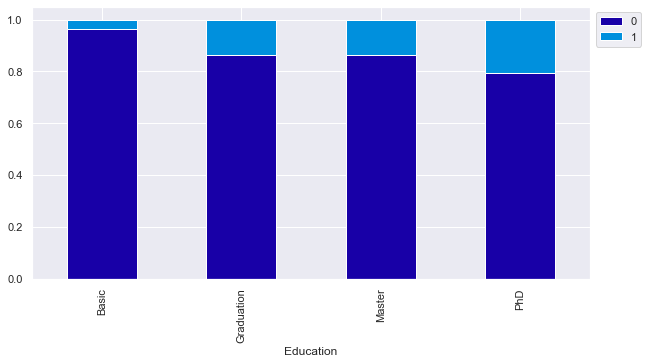

In [57]:
stacked_plot(data["Education"])

- We can see a clear trend here that customers with higher education are more likely to take the offer.  

Response           0    1   All
Marital_Status                 
Divorced         184   48   232
Married         1286  158  1444
Single           378  109   487
Widow             58   19    77
All             1906  334  2240
------------------------------------------------------------------------------------------------------------------------


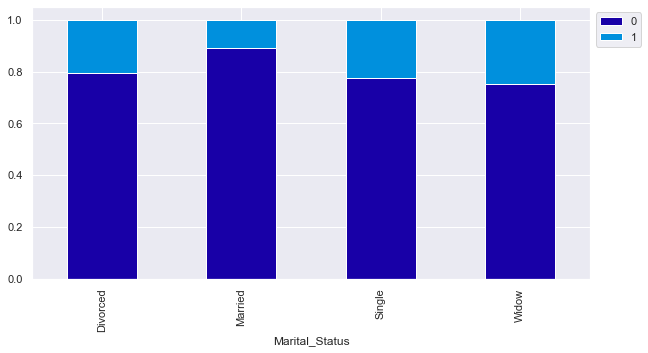

In [141]:
stacked_plot(data["Marital_Status"])

- We saw earlier that number of married customers are much more than single or divorced but divorced/widow customers are more likely to take the offer.
- Single customers are more likely to take the offer than married customers.

Response     0    1   All
Kidhome                  
0         1071  222  1293
1          789  110   899
2           46    2    48
All       1906  334  2240
------------------------------------------------------------------------------------------------------------------------


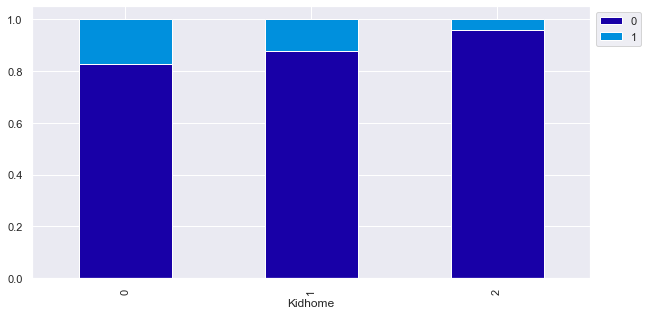

In [58]:
stacked_plot(data["Kidhome"])

- We can see that as number of kids increases, chances of customers taking the offer decreases.
- Customers with no kids at home are more likely to take the offer which can be expected as this includes single customers as well.

Response     0    1   All
Teenhome                 
0          921  237  1158
1          938   92  1030
2           47    5    52
All       1906  334  2240
------------------------------------------------------------------------------------------------------------------------


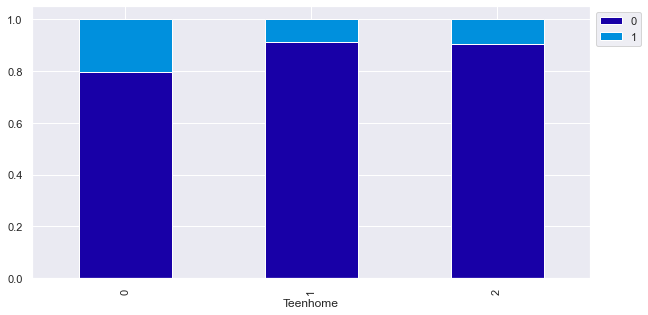

In [143]:
stacked_plot(data["Teenhome"])

- Customers with no teens at home are most likely to take the offer.
- Customers with two teens are more likely to take the offer than customers with 1 teenager.

Response     0    1   All
Reg_year                 
2012       362  132   494
2013      1035  154  1189
2014       509   48   557
All       1906  334  2240
------------------------------------------------------------------------------------------------------------------------


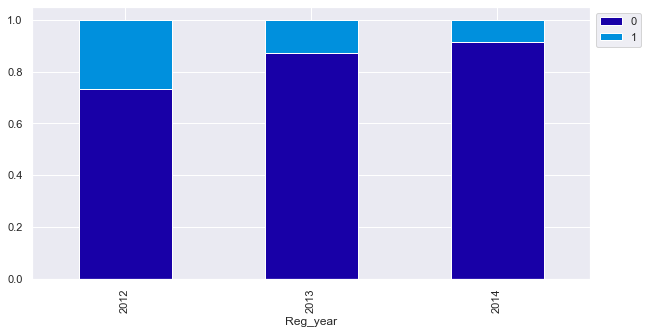

In [144]:
stacked_plot(data["Reg_year"])

- Number of customers taking the offer is decreasing each subsequent year.
- Let's explore this further for month wise distribution for each of the year.

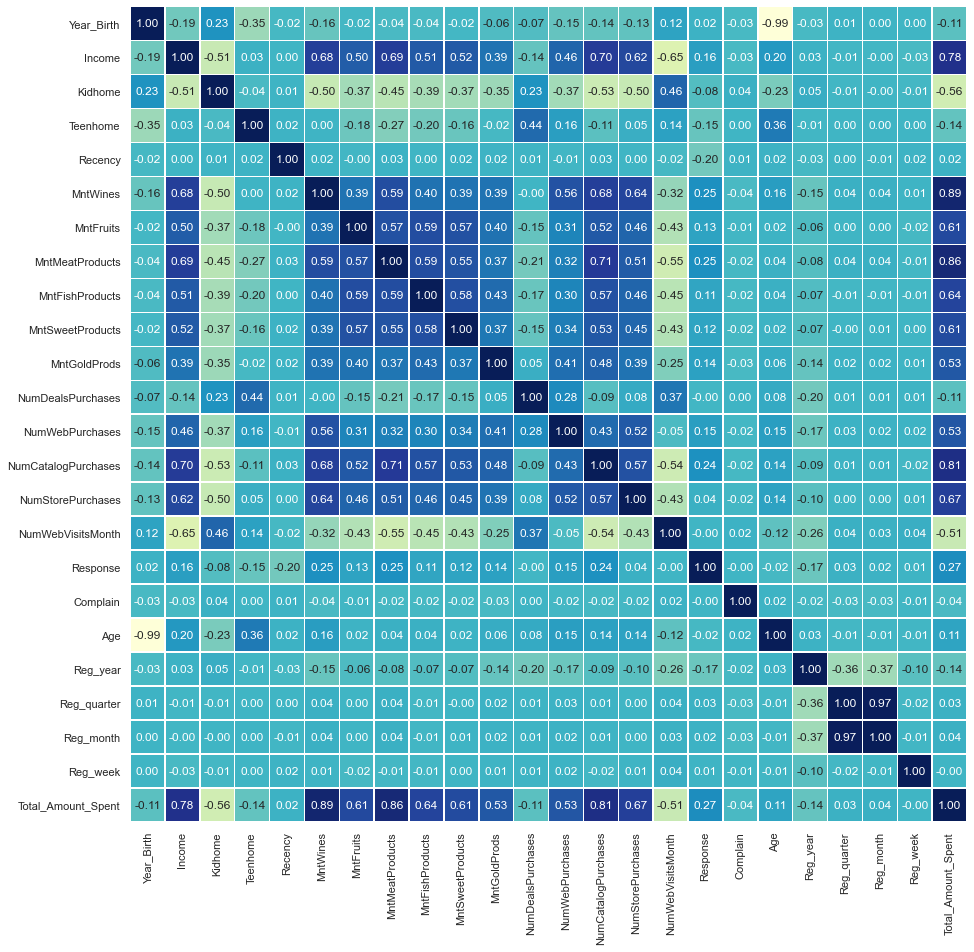

In [145]:
sns.set(rc={"figure.figsize": (15, 15)})
sns.heatmap(
    data.corr(),
    annot=True,
    linewidths=0.5,
    center=0,
    cbar=False,
    cmap="YlGnBu",
    fmt="0.2f",
)
plt.show()

- As expected, age and year birth have high negative correlation. We can drop one of them.
- Registration month, quarter and year columns are highly correlated which can be expected as we extracted these columns from the same column.
- We can drop one of the columns in quarter or month as they are almost perfectly correlated.
- Total amount spent is correlated with variables they are associate with. We can drop this column.
- Number of purchases is positively correlated with income which can be expected as customers with higher income might spend more than customers with lower income.

## Data Preparation

In [59]:
education = {'Basic':1, 'Graduation':2, 'Master':3, 'PhD':4}
data['Education']=data['Education'].map(education)
marital_status = {'Married':1,'Single':2, 'Divorced':3, 'Widow':4}
data['Marital_Status']=data['Marital_Status'].map(marital_status)

**Split the data into train and test sets** 

In [60]:
# Separating target variable and other variables
X = data.drop(columns="Response")
Y = data["Response"]

In [61]:
# Dropping birth year and Dt_Customer columns
X.drop(
    columns=[
        "Year_Birth",
        "Dt_Customer",
        "Reg_quarter",
        "Total_Amount_Spent",
    ],
    inplace=True,
)

In [62]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1, stratify=Y
)
print(X_train.shape, X_test.shape)

(1568, 22) (672, 22)


### Missing-Value Treatment

* We will use KNN imputer to impute missing values.
* `KNNImputer`: Each sample's missing values are imputed by looking at the n_neighbors nearest neighbors found in the training set. Default value for n_neighbors=5.
* KNN imputer replaces missing values using the average of k nearest non-missing feature values.
* Nearest points are found based on euclidean distance.

In [63]:
imputer = KNNImputer(n_neighbors=5)

In [64]:
#Fit and transform the train data
X_train=pd.DataFrame(imputer.fit_transform(X_train),columns=X_train.columns)

#Transform the test data 
X_test=pd.DataFrame(imputer.transform(X_test),columns=X_test.columns)

In [65]:
#Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print('-'*30)
print(X_test.isna().sum())

Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
Complain               0
Age                    0
Reg_year               0
Reg_month              0
Reg_week               0
dtype: int64
------------------------------
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWeb

* All missing values have been treated.
* Let's inverse map the encoded values.

In [66]:
## Function to inverse the encoding
def inverse_mapping(x,y):
    inv_dict = {v: k for k, v in x.items()}
    X_train[y] = np.round(X_train[y]).map(inv_dict).astype('category')
    X_test[y] = np.round(X_test[y]).map(inv_dict).astype('category')

In [67]:
inverse_mapping(education,'Education')
inverse_mapping(marital_status,'Marital_Status')

* Checking inverse mapped values/categories.

In [68]:
cols = X_train.select_dtypes(include=['object','category'])
for i in cols.columns:
    print(X_train[i].value_counts())
    print('*'*30)

Graduation    801
Master        399
PhD           332
Basic          36
Name: Education, dtype: int64
******************************
Married     987
Single      349
Divorced    177
Widow        55
Name: Marital_Status, dtype: int64
******************************


In [69]:
cols = X_test.select_dtypes(include=['object','category'])
for i in cols.columns:
    print(X_train[i].value_counts())
    print('*'*30)

Graduation    801
Master        399
PhD           332
Basic          36
Name: Education, dtype: int64
******************************
Married     987
Single      349
Divorced    177
Widow        55
Name: Marital_Status, dtype: int64
******************************


* Inverse mapping returned original labels.

### Encoding categorical varaibles

In [72]:
X_train.dtypes

Education              category
Marital_Status         category
Income                  float64
Kidhome                 float64
Teenhome                float64
Recency                 float64
MntWines                float64
MntFruits               float64
MntMeatProducts         float64
MntFishProducts         float64
MntSweetProducts        float64
MntGoldProds            float64
NumDealsPurchases       float64
NumWebPurchases         float64
NumCatalogPurchases     float64
NumStorePurchases       float64
NumWebVisitsMonth       float64
Complain                float64
Age                     float64
Reg_year               category
Reg_month              category
Reg_week               category
dtype: object

In [71]:
X_train.Reg_month = X_train.Reg_month.astype('category')
X_train.Reg_year = X_train.Reg_year.astype('category')
X_train.Reg_week = X_train.Reg_week.astype('category')
X_test.Reg_month = X_test.Reg_month.astype('category')
X_test.Reg_year = X_test.Reg_year.astype('category')
X_test.Reg_week = X_test.Reg_week.astype('category')


In [73]:
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)
print(X_train.shape, X_test.shape)

(1568, 40) (672, 40)


* After encoding there are 26 columns.

## Building the model

### Model evaluation criterion:

#### Model can make wrong predictions as:
1. Predicting a customer will buy the product and the customer doesn't buy - Loss of resources
2. Predicting a customer will not buy the product and the customer buys - Loss of opportunity

#### Which case is more important? 
* Predicting that customer will not buy the product but he buys i.e. losing on a potential source of income for the company because that customer will not targeted by the marketing team when he should be targeted.

#### How to reduce this loss i.e need to reduce False Negatives?
* Company wants Recall to be maximized, greater the Recall lesser the chances of false negatives.

**Let's start by building different models using KFold and cross_val_score with pipelines and tune the best model using GridSearchCV and RandomizedSearchCV**

- `Stratified K-Folds cross-validator` provides dataset indices to split data in train/validation sets. Split dataset into k consecutive folds (without shuffling by default) keeping distribution of both classes in each fold same as the target variable. Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

In [74]:
models = []  # Empty list to store all the models

# Appending pipelines for each model into the list
models.append(
    (
        "LR",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("log_reg", LogisticRegression(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "RF",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("random_forest", RandomForestClassifier(random_state=1)),
            ]
        ),
    )
)

models.append(
    (
        "GBM",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("gradient_boosting", GradientBoostingClassifier(random_state=1)),
            ]
        ),
    )
)





models.append(
    (
        "ADB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("adaboost", AdaBoostClassifier(random_state=1)),
            ]
        ),
    )
)



models.append(
    (
        "XGB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("xgboost", XGBClassifier(random_state=1,eval_metric='logloss')),
            ]
        ),
    )
)




models.append(
    (
        "DTREE",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("decision_tree", DecisionTreeClassifier(random_state=1)),
            ]
        ),
    )
)

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
for name, model in models:
    scoring = "recall"
    
    kfold = StratifiedKFold(
        n_splits=3, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    
    results.append(cv_result)
    
    
    names.append(name)
    
    print("{}: {}".format(name, cv_result.mean() * 100))

LR: 28.632478632478637
RF: 17.094017094017097
GBM: 34.615384615384606
ADB: 34.615384615384606
XGB: 36.324786324786324
DTREE: 40.598290598290596


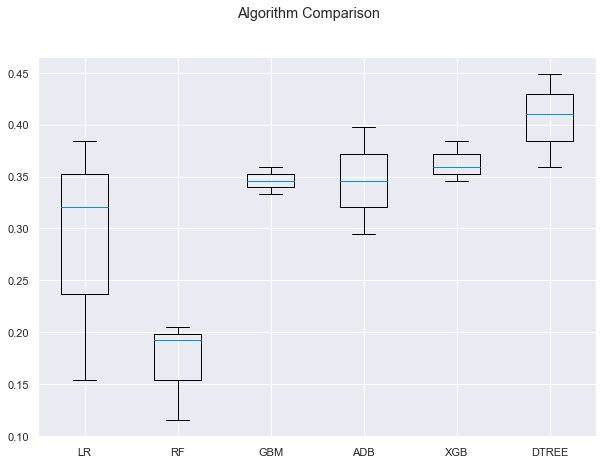

In [75]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

- We can see that AdaBoost is giving the highest cross validated recall followed by XGBoost
- The boxplot shows that the performance of both the models is consistent with just one outlier for AdaBoost.
- We will tune both models - AdaBoost and XGBoost and see if the performance improves. 

## Hyperparameter Tuning

**We will use pipelines with StandardScaler and  AdaBoost model and tune the model using GridSearchCV and RandomizedSearchCV. We will also compare the performance and time taken by these two methods - grid search and randomized search.**

**We can also use make_pipeline function instead of Pipeline to create a pipeline.**

**`make_pipeline`: This is a shorthand for the Pipeline constructor; it does not require, and does not permit, naming the estimators. Instead, their names will be set to the lowercase of their types automatically.**

**Fist, let's create two functions to calculate different metrics and confusion matrix, so that we don't have to use the same code repeatedly for each model.**

In [76]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model, flag=True):
    """
    model : classifier to predict values of X

    """
    # defining an empty list to store train and test results
    score_list = []

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    train_recall = metrics.recall_score(y_train, pred_train)
    test_recall = metrics.recall_score(y_test, pred_test)

    train_precision = metrics.precision_score(y_train, pred_train)
    test_precision = metrics.precision_score(y_test, pred_test)

    score_list.extend(
        (
            train_acc,
            test_acc,
            train_recall,
            test_recall,
            train_precision,
            test_precision,
        )
    )

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ", model.score(X_train, y_train))
        print("Accuracy on test set : ", model.score(X_test, y_test))
        print("Recall on training set : ", metrics.recall_score(y_train, pred_train))
        print("Recall on test set : ", metrics.recall_score(y_test, pred_test))
        print(
            "Precision on training set : ", metrics.precision_score(y_train, pred_train)
        )
        print("Precision on test set : ", metrics.precision_score(y_test, pred_test))

    return score_list  # returning the list with train and test scores

In [77]:
## Function to create confusion matrix
def make_confusion_matrix(model, y_actual, labels=[1, 0]):
    """
    model : classifier to predict values of X
    y_actual : ground truth

    """
    y_predict = model.predict(X_test)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(
        cm,
        index=[i for i in ["Actual - No", "Actual - Yes"]],
        columns=[i for i in ["Predicted - No", "Predicted - Yes"]],
    )
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## AdaBoost

### GridSearchCV

In [78]:
%%time 

# Creating pipeline
pipe = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "adaboostclassifier__n_estimators": np.arange(10, 60, 10),
    "adaboostclassifier__learning_rate": [0.1, 0.01, 0.05],
    "adaboostclassifier__base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=3)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'adaboostclassifier__base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1), 'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 50} 
Score: 0.23931623931623933
Wall time: 18.3 s


In [79]:
# Creating new pipeline with best parameters
abc_tuned1 = make_pipeline(
    StandardScaler(),
    AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=3, random_state=1),
        n_estimators=50,
        learning_rate=.1,
        random_state=1,
    ),
)

# Fit the model on training data
abc_tuned1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                          random_state=1),
                                    learning_rate=0.1, random_state=1))])

Accuracy on training set :  0.9323979591836735
Accuracy on test set :  0.8660714285714286
Recall on training set :  0.5897435897435898
Recall on test set :  0.3
Precision on training set :  0.9324324324324325
Precision on test set :  0.6


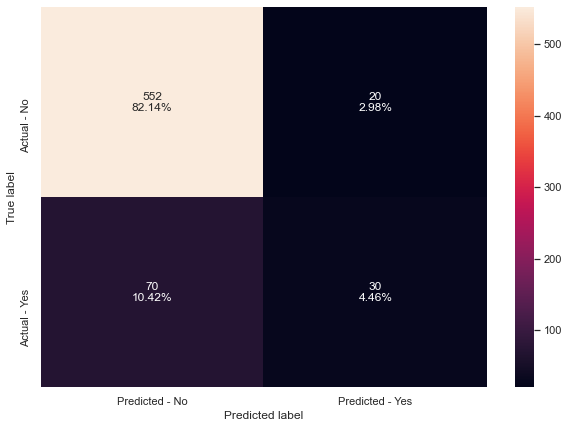

In [80]:
# Calculating different metrics
get_metrics_score(abc_tuned1)

# Creating confusion matrix
make_confusion_matrix(abc_tuned1, y_test)

- The test recall has increased by ~11% as compare to cross validated recall
- The tuned adaboost model is slightly overfitting the training data
- The test recall is still less than 50% i.e. the model is not good at identifying potential customers who would take the offer.

### RandomizedSearchCV

In [81]:
%%time

# Creating pipeline
pipe = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "adaboostclassifier__n_estimators": np.arange(10, 110, 10),
    "adaboostclassifier__learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "adaboostclassifier__base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
abc_tuned2 = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=3, random_state=1)

#Fitting parameters in RandomizedSearchCV
abc_tuned2.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(abc_tuned2.best_params_,abc_tuned2.best_score_))

Best parameters are {'adaboostclassifier__n_estimators': 90, 'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1)} with CV score=0.40598290598290593:
Wall time: 38.3 s


- Grid search took significantly longer time than random search. This difference would further increase as the number of parameters increases but the parameters from random search are exactly the same as compared grid search.
- This can happen by chance but it is not guaranteed to happen for each algorithm.

## XGBoost

### GridSearchCV

In [82]:
%%time 

#Creating pipeline
pipe=make_pipeline(StandardScaler(), XGBClassifier(random_state=1,eval_metric='logloss'))

#Parameter grid to pass in GridSearchCV
param_grid={'xgbclassifier__n_estimators':np.arange(50,220,50),
            'xgbclassifier__learning_rate':[0.01,0.1,0.2],
            'xgbclassifier__subsample':[0.7,0.9,1]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

#Fitting parameters in GridSeachCV
grid_cv.fit(X_train,y_train)


print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

Best parameters are {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7} with CV score=0.43598519888991677:
Wall time: 48.9 s


In [83]:
# Creating new pipeline with best parameters
xgb_tuned1 = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        random_state=1,
        n_estimators=200,
        subsample=0.7,
        learning_rate=0.1,
        eval_metric='logloss',
    ),
)

# Fit the model on training data
xgb_tuned1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=8, num_parallel_tree=1, random_state=1,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.7, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

Accuracy on training set :  0.9942602040816326
Accuracy on test set :  0.8824404761904762
Recall on training set :  0.9700854700854701
Recall on test set :  0.46
Precision on training set :  0.9912663755458515
Precision on test set :  0.647887323943662


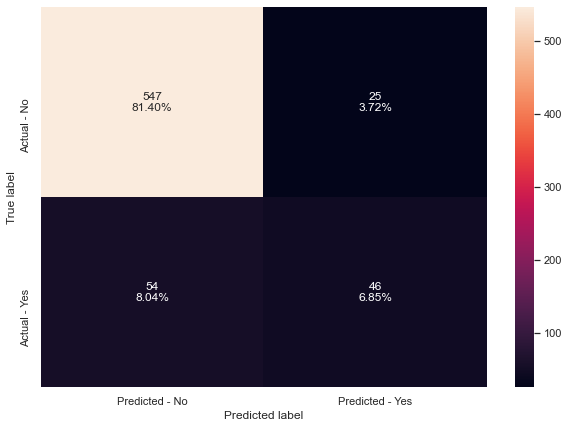

In [172]:
# Calculating different metrics
get_metrics_score(xgb_tuned1)

# Creating confusion matrix
make_confusion_matrix(xgb_tuned1, y_test)

- The test recall has increased by ~40% as compared to the result from cross validation with default parameters.
- The model is overfitting the training data.

### RandomizedSearchCV

In [173]:
%%time 

#Creating pipeline
pipe=make_pipeline(StandardScaler(),XGBClassifier(random_state=1,eval_metric='logloss', n_estimators = 50))

#Parameter grid to pass in GridSearchCV
param_grid={'xgbclassifier__n_estimators':np.arange(50,300,50),
            'xgbclassifier__learning_rate':[0.01,0.1,0.2,0.05],
            'xgbclassifier__subsample':[0.7,0.8,0.9,1],
           'xgbclassifier__max_depth':np.arange(1,10,1),
            'xgbclassifier__reg_lambda':[0,1,2,5,10]}





# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'xgbclassifier__subsample': 0.8, 'xgbclassifier__reg_lambda': 5, 'xgbclassifier__n_estimators': 250, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.1} with CV score=0.46160962072155415:
Wall time: 2min 21s


In [174]:
# Creating new pipeline with best parameters
xgb_tuned2 = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "XGB",
            XGBClassifier(
                random_state=1,
                n_estimators=200,
                scale_pos_weight=10,
                gamma=1,
                subsample=0.9,
                learning_rate= 0.01,
                eval_metric='logloss', max_depth = 2, reg_lambda = 2
            ),
        ),
    ]
)
# Fit the model on training data
xgb_tuned2.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=1, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=4, num_parallel_tree=1, random_state=1,
                               reg_alpha=0, reg_lambda=2, scale_pos_weight=10,
                               subsample=0.9, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

Accuracy on training set :  0.5605867346938775
Accuracy on test set :  0.5967261904761905
Recall on training set :  0.9529914529914529
Recall on test set :  0.85
Precision on training set :  0.24750277469478357
Precision on test set :  0.24926686217008798


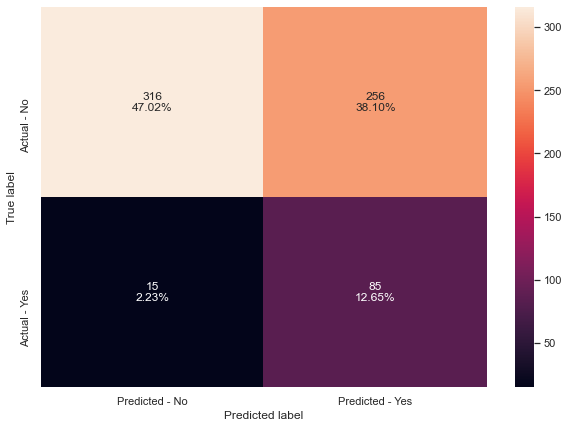

In [175]:
# Calculating different metrics
get_metrics_score(xgb_tuned2)

# Creating confusion matrix
make_confusion_matrix(xgb_tuned2, y_test)

- Random search is giving better results than Grid search.
- The test recall has increased as compared to the test recall from grid search but the accuracy and precision has decreased.
- The overfitting in the model has also decreased

## Comparing all models

In [176]:
# defining list of models
models = [abc_tuned1, abc_tuned2, xgb_tuned1, xgb_tuned2]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:

    j = get_metrics_score(model, False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

In [178]:
comparison_frame = pd.DataFrame(
    {
        "Model": [
            "Random Forest with GridSearchCV",
            "Random Forest with RandomizedSearchCV",
            "XGBoost with GridSearchCV",
            "XGBoost with RandomizedSearchCV"
                        
        ],
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
    }
)

# Sorting models in decreasing order of test recall
comparison_frame.sort_values(by="Test_Recall", ascending=False)

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
3,XGBoost with RandomizedSearchCV,0.560587,0.596726,0.952991,0.85,0.247503,0.249267
0,Random Forest with GridSearchCV,0.994260,0.869048,0.974359,0.49,0.987013,0.569767
1,Random Forest with RandomizedSearchCV,0.974359,0.490000,0.974359,0.49,0.987013,0.569767
2,XGBoost with GridSearchCV,0.994260,0.882440,0.970085,0.46,0.991266,0.647887


In [85]:
import pickle

In [87]:
pickle.dump(xgb_tuned1, open("model.obj","wb"))

- The xgboost model tuned using randomised search is giving the best test recall of 0.87 but it has the least train and test precision.
- Let's see the feature importance from the tuned xgboost model

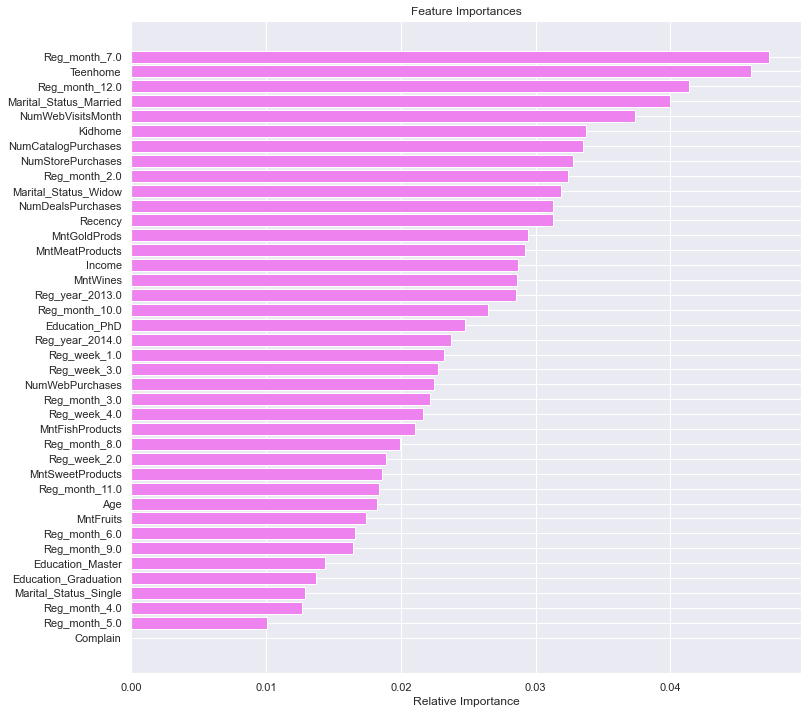

In [88]:
feature_names = X_train.columns
importances = xgb_tuned1[1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- Amount spent on gold products is the most important feature, followed by NumCatalogPurchases and Recency of the customer.

## Business Recommendations

- Company should target customers who buy premium products - gold products or high quality wines - as these customers are able to spend more and are more likely to purchase the offer. The company should further launch premium offers for such customers. Such offers can also be extended to customers with higher income. 
- We observed in our analysis that ~64% of customers are married but single customers, including divorced and widowed, are more  equally or more likely to take the offer. Company should expand their customers by customizing offers to attract more single customers.
- Customers who are frequent buyers, should be targeted more by the company and offer them added benefits.
- Total amount spent has decreased over the years which shows that either our product qualities has declined or company lacks marketing strategies. Company should constantly improve their marketing strategies to address such issues.
- Our analysis showed that ~99% customers had no complaints in the last two years which can be due to the lack of feedback options for customers. Company should create easy mechanisms to gather feedback from the customers and use it to identify major concerns, if any.
- The number of web visits is an important feature and company should work on customizing their website to allow more traffic on the website. Company can improve the interface and provide easy check-in, check-out and delivery options.